## Baseline models (done correctly)

Due to advice from teammates must split the data first and then encode. Will rework all of that here and also play around with features to see if there are different results and also when we split the data on jan and feb instead of random. First will be the basic and then I will move on to the extras to compare.

In [3]:
import pandas as pd
import numpy as np
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import datetime


In [4]:
# Load your dataset
print("Current working directory:", os.getcwd())

# Let user select their local file
#Tk().withdraw()  # Hide the root window
file_path = askopenfilename(title="Select your local final cleaned taxi data CSV")

# Check and load
if not file_path or not os.path.exists(file_path):
    raise FileNotFoundError("File not found or not selected.")
else:
    df = pd.read_csv(file_path)
    print("Loaded file:", file_path)
    print("Initial shape:", df.shape)
print(f"Dataset loaded successfully! Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")


Current working directory: c:\diksha\Summer Sem\DataAnalysis\Notebooks
Loaded file: C:/diksha/Summer Sem/DataAnalysis/Data/cleaned/final_cleaned_jan_feb_2023_taxi_data.csv
Initial shape: (5646828, 19)
Dataset loaded successfully! Shape: (5646828, 19)
Columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour', 'pickup_day_of_week', 'pickup_borough', 'pickup_zone', 'pickup_service_zone', 'dropoff_borough', 'dropoff_zone', 'dropoff_service_zone', 'fare_per_minute', 'trip_speed', 'trip_speed_mph', 'time_of_day', 'is_weekend']


In [5]:

#prep the data
# Separate features and target
X = df.drop(columns=['fare_per_minute'])  #features
y = df['fare_per_minute'] #target variable

#  drop rows with missing target to avoid issues during training
print(f"Before: {df.shape[0]} rows")
df = df[df['fare_per_minute'].notna()]
print(f"After removing missing targets: {df.shape[0]} rows")  # to clarify the datasize 


# Before encoding do a train-test split
X_train, X_test, y_train, y_test = train_test_split(  #this makes sure y is clean before splitting
    X, y, test_size=0.2, random_state=42
)

Before: 5646828 rows
After removing missing targets: 5646828 rows


## Made a function for encoding that can be reused later on 

In [10]:
# Base encodings: binary, one-hot, ordinal
def base_encode(df):
    df_encoded = df.copy()

    # 1. Binary encoding
    df_encoded['is_weekend'] = df_encoded['is_weekend'].astype(int)

    # 2. One-hot encoding
    onehot_cols = ['pickup_borough', 'dropoff_borough', 'pickup_service_zone', 'dropoff_service_zone']
    df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, drop_first=True)

    # 3. Ordinal encoding
    time_order = {
        'Early Morning': 0,
        'Morning Rush': 1,
        'Midday': 2,
        'Evening Rush': 3,
        'Night': 4
    }
    df_encoded['time_of_day_encoded'] = df_encoded['time_of_day'].map(time_order)
    df_encoded.drop('time_of_day', axis=1, inplace=True)

    return df_encoded

# CV-safe target encoding
def target_encode_train_and_apply(train_df, test_df, target_column, zone_columns):
    """
    Applies K-Fold target encoding on training set, and uses those mappings for test set.

    Args:
        train_df: training DataFrame (must include target column)
        test_df: test DataFrame (must include target column, only for evaluation)
        target_column: name of the target variable (str)
        zone_columns: list of high-cardinality columns to encode (list of str)

    Returns:
        train_df_encoded, test_df_encoded
    """
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for col in zone_columns:
        new_col = f"{col}_target_encoded"
        train_encoded[new_col] = np.nan

        # Step 1: Encode training set with KFold
        for train_idx, val_idx in kf.split(train_df):
            train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]
            means = train_fold.groupby(col)[target_column].mean()
            train_encoded.loc[val_fold.index, new_col] = val_fold[col].map(means)


        # Step 2: Create final mapping from full training set
        final_means = train_df.groupby(col)[target_column].mean()

        # Step 3: Apply the mapping to the test set
        test_encoded[new_col] = test_df[col].map(final_means)

        # Drop original categorical column (optional)
        train_encoded.drop(columns=col, inplace=True)
        test_encoded.drop(columns=col, inplace=True)

    return train_encoded, test_encoded

In [15]:
# Combine features + target for encoding
X_train_full = X_train.copy()
X_train_full['fare_per_minute'] = y_train

X_test_full = X_test.copy()
X_test_full['fare_per_minute'] = y_test

# Add y temporarily for encoding
X_train_base = base_encode(X_train_full)
X_test_base = base_encode(X_test_full)

# Apply encoding by calling the functions made earlier
X_train_final, X_test_final = target_encode_train_and_apply(
    X_train_base, X_test_base, 
    target_column='fare_per_minute', 
    zone_columns=['pickup_zone', 'dropoff_zone']
)
# Drop unused datetime columns (now that features are extracted)
cols_to_drop = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_date']
X_train_final.drop(columns=cols_to_drop, inplace=True, errors='ignore')
X_test_final.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Separate target again
y_train_final = X_train_final['fare_per_minute']
y_test_final = X_test_final['fare_per_minute']

X_train_final.drop(columns=['fare_per_minute'], inplace=True)
X_test_final.drop(columns=['fare_per_minute'], inplace=True)

## Training LightGBM Model

Because as of right now the dataframe still has datetime columns in string (object) format LightGBM cannot train on object or string types becausse it only supports: int, float, bool we must drop unused datetime columns (since we already extracted useful features such as pickup_hour, day_of_week we can drop them before training) 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.220519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 4517462, number of used features: 27
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.264910
Training until validation scores don't improve for 10 rounds
[10]	training's l1: 0.161277	valid_1's l1: 0.161214
[20]	training's l1: 0.105732	valid_1's l1: 0.105677
[30]	training's l1: 0.0738747	valid_1's l1: 0.0738284
[40]	training's l1: 0.0563605	valid_1's l1: 0.056346
[50]	training's l1: 0.0469531	valid_1's l1: 0.046953
[60]	training's l1: 0.0417852	valid_1's l1: 0.0417991
[70]	training's l1: 0.0384372	valid_1's l1: 0.0384622

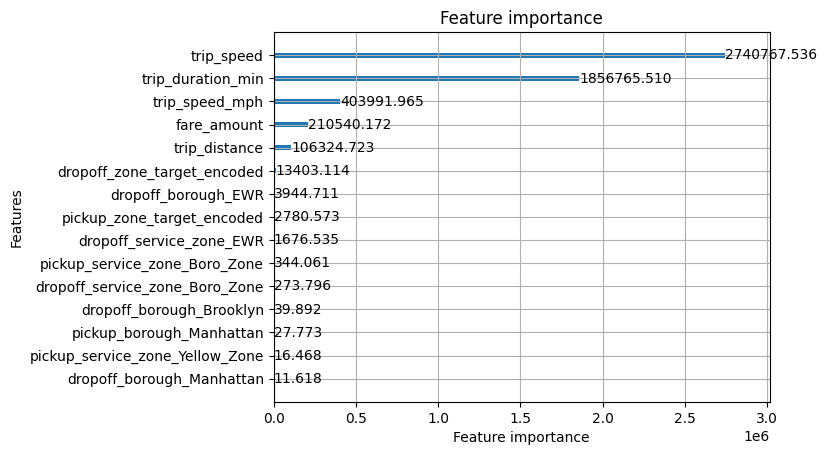

In [16]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train_final, label=y_train_final)
test_data = lgb.Dataset(X_test_final, label=y_test_final, reference=train_data)

# Parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=100,
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10)
    ]
)

# Evaluate
y_pred = model.predict(X_test_final)
print("MAE:", mean_absolute_error(y_test_final, y_pred))
print("R² Score:", r2_score(y_test_final, y_pred))

# Plot feature importance
lgb.plot_importance(model, max_num_features=15, importance_type='gain');


## Discussion for LIghtGBM

1. Found whitespace should go ahead and rename features to avoid whitespace such as pickup zone in the data cleaning. This model already replaced the whitespace with _ 

2. Auto-Choosing row wise multi-threading: this just auto selects a method of handling data in memory (rows) and gives advice if memory becayse a bottelneck later 

3. Total Bins 1855 - lightgbm discretizes (bins) continous features  LightGBM took all the continuous features and grouped their values into 1855 buckets (or ranges) total.

4. MAE (Mean Absolute Error): On average, the model’s predicted fare_per_minute is off by ~3.3 cents which is the same as when we looked into the modeling when encoding the enitre dataset and is something to investigate even further

5. R² Score: 0.9787 means the model explains ~97.87% of the variance in the target.  Once again same as our previous model and is suspicious

## Retrain LightGBM without Leakage Features

target is fare per minute but we are using fare amount and trip duration to calc fare per minute but are also using them as features for this model which could lead to the high numbers we are seeing  also do encoding after splitting the dat. remove them to see if they change the score

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1345
[LightGBM] [Info] Number of data points in the train set: 4517462, number of used features: 25
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.264910
Training until validation scores don't improve for 10 rounds
[10]	training's l1: 0.163135	valid_1's l1: 0.163056
[20]	training's l1: 0.111142	valid_1's l1: 0.111076
[30]	training's l1: 0.0792029	valid_1's l1: 0.0791371
[40]	training's l1: 0.0621985	valid_1's l1: 0.0621547
[50]	training's l1: 0.0528838	valid_1's l1: 0.052867
[60]	training's l1: 0.0487338	valid_1's l1: 0.0487413
[70]	training's l1: 0.0468393	valid_1's l1: 0.046858

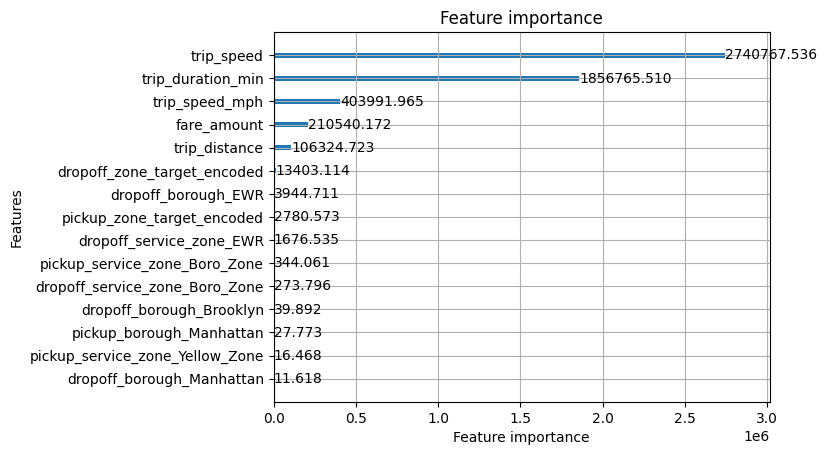

In [21]:
# Create new versions without the leakage features
X_train_noleak = X_train_final.drop(['fare_amount', 'trip_duration_min'], axis=1)
X_test_noleak = X_test_final.drop(['fare_amount', 'trip_duration_min'], axis=1)

# Retrain LightGBM
train_data_noleak = lgb.Dataset(X_train_noleak, label=y_train_final)
test_data_noleak = lgb.Dataset(X_test_noleak, label=y_test_final, reference=train_data_noleak)

model_noleak = lgb.train(
    params,
    train_data_noleak,
    valid_sets=[train_data_noleak, test_data_noleak],
    num_boost_round=100,
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10)
    ]
)

# Evaluate
y_pred_noleak = model_noleak.predict(X_test_noleak)
mae_noleak = mean_absolute_error(y_test_final, y_pred_noleak)
r2_noleak = r2_score(y_test_final, y_pred_noleak)

print(f"MAE without leakage features: {mae_noleak:.3f}")
print(f"R² Score without leakage features: {r2_noleak:.3f}")

# Plot feature importance
lgb.plot_importance(model, max_num_features=15, importance_type='gain');


## No Leakage LightGBM Discussion

Without fare_amount and trip_duration_min the MAE and R2 scores do change meaning that the previous model was benifitting from target leakage since the very features used to calculate the target were also inputs

1. MAE score: 0.045 it increased from 0.033

2. R sqaured: 0.957 decreased which follows

Though the scores have changed it still shows that the model performs very well, meaning that our other features like location time of day day of week zone encodings are doing a good job.

Going forward we will keep this as the offical clean protoype though when presenting/ reporting it would be good to show both metrics

3. Further research can be done to boost performance: we can try feature engineering 

## Linear Regression Baseline Model 

I will now use the no leakage data to train a linear regression model to help understand feature realtionships, do a sanity check (ensuring that boossted model is actually learning non-linear patterns and not overfitting), will also give us a refrence point, if lightgbm is only slighlty better than linear maybe we need to relook at it due to being either too simple or too clean

Since linear cannot handle NaN need to drop any rows that have that 

In [24]:
# Drop rows with NaNs from training and test sets
X_train_noleak_clean = X_train_noleak.dropna()
y_train_clean = y_train_final.loc[X_train_noleak_clean.index]

X_test_noleak_clean = X_test_noleak.dropna()
y_test_clean = y_test_final.loc[X_test_noleak_clean.index]

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train_noleak_clean, y_train_clean)

# Predict
y_pred_lr = lr_model.predict(X_test_noleak_clean)

# Evaluate
mae_lr = mean_absolute_error(y_test_clean, y_pred_lr)
r2_lr = r2_score(y_test_clean, y_pred_lr)

print(f"Linear Regression MAE: {mae_lr:.3f}")
print(f"Linear Regression R²: {r2_lr:.3f}")



Linear Regression MAE: 0.122
Linear Regression R²: 0.721


## No Leakage Linear Discussion

1. Linear Regression (baseline model) without the leakage features scored:

MAE: 0.122

R²: 0.721

Compared to the LightGBM model without leakage:

MAE: 0.045

R²: 0.957

2. LightGBM clearly outperforms Linear Regression by a large margin.

The baseline model (Linear Regression) provides a good performance floor. It shows how well a simple model performs on the same features.

The big jump in R² suggests that the engineered features and encoding are adding significant predictive power — and LightGBM is doing a much better job capturing non-linear relationships.

3. No need to improve on this model

